# Compare classification methods for identifying org. science perspectives in JSTOR articles
## Using balanced samples from hand-labeled set of articles

@author: Jaren Haber, PhD<br>
@coauthors: Prof. Heather Haveman, UC Berkeley; Yoon Sung Hong, Wayfair<br>
@contact: Jaren.Haber@georgetown.edu<br>
@project: Computational Literature Review of Organizational Scholarship<br>
@date: December 2020

'''
Trains classifiers to predict whether an article is about a given perspective in org. science. To train the classifiers, uses preliminary labeled articles, broken down as follows: 
Cultural: 105 yes, 209 no
Relational: 92 yes, 230 no
Demographic: 77 yes, 249 no
Compares f1_weighted scores of four model structures using 10-Fold Cross Validation: Logistic regression, SVM, Naive Bayes, and Decision Tree. Oversamples training data to .7 (7:10 minority:majority class).
'''

## Initialize

In [2]:
!pip install -U imbalanced-learn
!pip install nltk

Requirement already up-to-date: imbalanced-learn in /opt/conda/lib/python3.7/site-packages (0.7.0)


In [3]:
!pip install mxnet

In [1]:
######################################################
# Import libraries
######################################################

import pandas as pd
import numpy as np
import re
from collections import Counter
from datetime import date
from tqdm import tqdm
import os

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')

stemmer = WordNetLemmatizer()

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

import joblib
import csv

from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, KFold

import mxnet as mx
from mxnet import nd, autograd, gluon
ctx = mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()
data_ctx = ctx
model_ctx = ctx


from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import sys; sys.path.insert(0, "../preprocess/") # For loading functions from files in other directory
from quickpickle import quickpickle_dump, quickpickle_load # custom scripts for quick saving & loading to pickle format
from text_to_file import write_textlist, read_text # custom scripts for reading and writing text lists to .txt files

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
######################################################
# Define filepaths
######################################################

thisday = date.today().strftime("%m%d%y")

cwd = os.getcwd()
root = str.replace(cwd, 'classification/modeling', '')

# Directory for prepared data and trained models: save files here
data_fp = root + 'classification/data/'
model_fp = root + 'classification/models/'

# Current article lists
article_list_fp = data_fp + 'filtered_length_index.csv' # Filtered index of research articles
article_paths_fp = data_fp + 'filtered_length_article_paths.csv' # List of article file paths

# Preprocessed training data
cult_labeled_fp = data_fp + 'training_cultural_preprocessed_121620.pkl'
relt_labeled_fp = data_fp + 'training_relational_preprocessed_121620.pkl'
demog_labeled_fp = data_fp + 'training_demographic_preprocessed_121620.pkl'

# Model filepaths
cult_model_fp = model_fp + f'classifier_cult_{str(thisday)}.joblib'
relt_model_fp = model_fp + f'classifier_relt_{str(thisday)}.joblib'
demog_model_fp = model_fp + f'classifier_demog_{str(thisday)}.joblib'

# Vectorizers trained on hand-coded data (use to limit vocab of input texts)
cult_vec_fp = model_fp + 'vectorizer_cult_121620.joblib'
relt_vec_fp = model_fp + 'vectorizer_relt_121620.joblib'
demog_vec_fp = model_fp + 'vectorizer_demog_121620.joblib'

## Load & inspect data

In [3]:
cult_df = quickpickle_load(cult_labeled_fp)
relt_df = quickpickle_load(relt_labeled_fp)
demog_df = quickpickle_load(demog_labeled_fp)

cult_df.head(10)

,text,cultural_score
0,"[[journal, of, managerial, issues, vol, xxiii,...",1.0
1,"[[organization, ht, icna, vol, no, may, june, ...",1.0
2,"[[from, fiefs, to, clans, and, network, capita...",1.0
3,"[[the, collective, strategy, framework, an, ap...",1.0
4,"[[manag, int, rev, doi, sl, research, article,...",1.0
5,"[[int, studies, ofmgt, amp, org, vol, no, pp, ...",1.0
6,"[[linking, organizational, values, to, relatio...",1.0
7,"[[journal, of, organizational, behavior, organ...",1.0
8,"[[®, academy, oí, management, learning, amp, e...",1.0
9,"[[strategie, management, journal, strat, mgmt,...",1.0


In [4]:
# Check score distribution across classes
print(cult_df.groupby('cultural_score').size())
print()
print(relt_df.groupby('relational_score').size())
print()
print(demog_df.groupby('demographic_score').size())

cultural_score
0.0    209
0.5     12
1.0    133
dtype: int64

relational_score
0.0    229
0.5      7
1.0    114
dtype: int64

demographic_score
0.0    248
0.5      5
1.0    101
dtype: int64


In [5]:
# Drop unsure cases: where X_score = 0.5
drop_unsure = True

if drop_unsure:
    cult_df_yes = cult_df[cult_df['cultural_score'] == 1.0]
    cult_df_no = cult_df[cult_df['cultural_score'] == 0.0]
    cult_df = pd.concat([cult_df_yes, cult_df_no])
    
    relt_df_yes = relt_df[relt_df['relational_score'] == 1.0]
    relt_df_no = relt_df[relt_df['relational_score'] == 0.0]
    relt_df = pd.concat([relt_df_yes, relt_df_no])
    
    demog_df_yes = demog_df[demog_df['demographic_score'] == 1.0]
    demog_df_no = demog_df[demog_df['demographic_score'] == 0.0]
    demog_df = pd.concat([demog_df_yes, demog_df_no])

### Check vocab size and frequent words

In [6]:
def collect_article_tokens(article, return_string=False):
    '''
    Collects words from already-tokenized sentences representing each article.
    
    Args:
        article: list of lists of words (each list is a sentence)
        return_string: whether to return single, long string representing article
    Returns:
        tokens: string if return_string, else list of tokens
    '''
    
    tokens = [] # initialize
    
    if return_string:
        for sent in article:
            sent = ' '.join(sent) # make sentence into a string
            tokens.append(sent) # add sentence to list of sentences
        tokens = ' '.join(tokens) # join sentences into string
        return tokens # return string
    
    else:
        for sent in article:
            tokens += [word for word in sent] # add each word to list of tokens
        return tokens # return list of tokens

# For capturing word frequencies, add all words from each article to single, shared list (can't use this to create models)
cult_tokens = []; cult_df['text'].apply(lambda article: cult_tokens.extend([word for word in collect_article_tokens(article)]))
relt_tokens = []; relt_df['text'].apply(lambda article: relt_tokens.extend([word for word in collect_article_tokens(article)]))
demog_tokens = []; demog_df['text'].apply(lambda article: demog_tokens.extend([word for word in collect_article_tokens(article)]))
print()

In [7]:
# Look at size of vocabulary and most frequent words
tokens = (cult_tokens + relt_tokens) + demog_tokens
print('Vocab size:', len(set(tokens)))
print()

# Check out most frequent words in labeled texts
freq = Counter(tokens)
print('20 most frequent words in labeled articles:')
freq.most_common(20)

Vocab size: 80217

20 most frequent words in labeled articles:


[('the', 596822),
 ('of', 428762),
 ('and', 330459),
 ('in', 232360),
 ('to', 218627),
 ('that', 117768),
 ('is', 103616),
 ('for', 94102),
 ('as', 76669),
 ('on', 63680),
 ('are', 63279),
 ('with', 59141),
 ('by', 57364),
 ('this', 53800),
 ('be', 47394),
 ('oasis', 46263),
 ('or', 42620),
 ('it', 40088),
 ('entry', 39972),
 ('from', 39891)]

### Check frequent sentences (to improve cleaning)

In [8]:
# Add sentences from each article to empty list:
cult_sents = []; cult_df['text'].apply(
    lambda article: cult_sents.extend(
        [' '.join([word for word in sent]) for sent in article]))
relt_sents = []; relt_df['text'].apply(
    lambda article: relt_sents.extend(
        [' '.join([word for word in sent]) for sent in article]))
demog_sents = []; demog_df['text'].apply(
    lambda article: demog_sents.extend(
        [' '.join([word for word in sent]) for sent in article]))

sents = (cult_sents + relt_sents) + demog_sents
print('Number of sentences:', len(sents))
print()

# Check out most frequent sentences in labeled texts
freq = Counter(sents)
print('20 most frequent sentences in labeled articles:')
freq.most_common(20)

Number of sentences: 133028

20 most frequent sentences in labeled articles:


[('colsep', 12325),
 ('rowsep', 12319),
 ('oasis entry colname', 11914),
 ('char', 7881),
 ('align char', 7802),
 ('valign bottom oasis entry', 7243),
 ('oasis row', 6022),
 ('align center', 2775),
 ('valign bottom', 2595),
 ('oasis entry colname colsep rowsep align char char oasis entry', 1589),
 ('align left', 1573),
 ('oasis entry colname colsep rowsep align char char', 1250),
 ('oasis entry colsep rowsep valign bottom oasis entry', 1045),
 ('label label', 767),
 ('fn', 744),
 ('sec', 606),
 ('oasis colspec colnum colname colwidth pi', 573),
 ('sec id sc', 560),
 ('oasis entry colsep rowsep oasis entry', 531),
 ('fn id fn', 509)]

### Load and apply text vectorizers

In [9]:
# Collect articles: Add each article as single str to list of str:
cult_docs = [] # empty list
cult_df['text'].apply(
    lambda article: cult_docs.append(
        collect_article_tokens(
            article, 
            return_string=True)))

relt_docs = [] # empty list
relt_df['text'].apply(
    lambda article: relt_docs.append(
       collect_article_tokens(
            article, 
            return_string=True)))

demog_docs = [] # empty list
demog_df['text'].apply(
    lambda article: demog_docs.append(
        collect_article_tokens(
            article, 
            return_string=True)))

print() # skip weird output

In [10]:
# Define stopwords used by JSTOR
jstor_stopwords = set(["a", "an", "and", "are", "as", "at", "be", "but", "by", "for", "if", "in", "into", "is", "it", "no", "not", "of", "on", "or", "such", "that", "the", "their", "then", "there", "these", "they", "this", "to", "was", "will", "with"])

# Uses TFIDF weighted DTM because results in better classifier accuracy than unweighted
cult_vectorizer = joblib.load(cult_vec_fp, "r+")
X_cult = cult_vectorizer.transform(cult_docs)
print('Number of features in cultural vectorizer:', len(cult_vectorizer.get_feature_names()))
print(cult_vectorizer.get_feature_names()[::1000]) # get every 1000th word
print()

relt_vectorizer = joblib.load(relt_vec_fp, "r+")
X_relt = relt_vectorizer.transform(relt_docs)
print('Number of features in relational vectorizer:', len(relt_vectorizer.get_feature_names()))
print(relt_vectorizer.get_feature_names()[::1000]) # get every 1000th word
print()

demog_vectorizer = joblib.load(demog_vec_fp, "r+")
X_demog = demog_vectorizer.transform(demog_docs)
print('Number of features in demographic vectorizer:', len(demog_vectorizer.get_feature_names()))
print(demog_vectorizer.get_feature_names()[::1000]) # get every 1000th word

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.23.2 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.23.2 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Number of features in cultural vectorizer: 66098
['aa', 'affects', 'analogize', 'argumentatively', 'aveni', 'beifuss', 'blustein', 'buchholtz', 'carron', 'childlessness', 'coinciding', 'confused', 'councillors', 'czabansku', 'demirguc', 'dijeffren', 'dogs', 'economets', 'endler', 'ethnidzed', 'fad', 'fiskarbankadministrasjon', 'frenzen', 'ger', 'greenwood', 'haskell', 'hobson', 'identified', 'indexes', 'interceded', 'itbs', 'kaleidoscope', 'kraiger', 'legalized', 'lockett', 'makrosoziologie', 'mcenough', 'millenarian', 'mot', 'ncjrs', 'noninstrumental', 'offaculty', 'oshpd', 'parsimonious', 'phase', 'poovanalingum', 'primatively', 'punctuate', 'readership', 'relabeled', 'review', 'ruddy', 'schneider', 'severed', 'site', 'sparrowe', 'stochas', 'superlative', 'taurus', 'thus', 'transitioning', 'ularco', 'unsafe', 'vessies', 'weekends', 'wrinkle', 'ïï']

Number of features in relational vectorizer: 64919
['aa', 'affordance', 'ancestors', 'arose', 'aydin', 'benefitted', 'bonacich', 'burkar

In [11]:
# check out column order for data once vectorizer has been applied (should be exactly the same as list from previous cell)
test = pd.DataFrame(X_cult.toarray(), columns=cult_vectorizer.get_feature_names())
print('Number of features in preprocessed text for training cultural classifier (after applying cultural vectorizer):', len(list(test)))
print(list(test)[::1000])
print()
test = pd.DataFrame(X_relt.toarray(), columns=relt_vectorizer.get_feature_names())
print('Number of features in preprocessed text for training relational classifier (after applying relational vectorizer):', len(list(test)))
print(list(test)[::1000])
print()
test = pd.DataFrame(X_demog.toarray(), columns=demog_vectorizer.get_feature_names())
print('Number of features in preprocessed text for training demographic classifier (after applying demographic vectorizer):', len(list(test)))
print(list(test)[::1000])

Number of features in preprocessed text for training cultural classifier (after applying cultural vectorizer): 66098
['aa', 'affects', 'analogize', 'argumentatively', 'aveni', 'beifuss', 'blustein', 'buchholtz', 'carron', 'childlessness', 'coinciding', 'confused', 'councillors', 'czabansku', 'demirguc', 'dijeffren', 'dogs', 'economets', 'endler', 'ethnidzed', 'fad', 'fiskarbankadministrasjon', 'frenzen', 'ger', 'greenwood', 'haskell', 'hobson', 'identified', 'indexes', 'interceded', 'itbs', 'kaleidoscope', 'kraiger', 'legalized', 'lockett', 'makrosoziologie', 'mcenough', 'millenarian', 'mot', 'ncjrs', 'noninstrumental', 'offaculty', 'oshpd', 'parsimonious', 'phase', 'poovanalingum', 'primatively', 'punctuate', 'readership', 'relabeled', 'review', 'ruddy', 'schneider', 'severed', 'site', 'sparrowe', 'stochas', 'superlative', 'taurus', 'thus', 'transitioning', 'ularco', 'unsafe', 'vessies', 'weekends', 'wrinkle', 'ïï']

Number of features in preprocessed text for training relational clas

## Setup for modeling

In [12]:
######################################################
# Balance x_train, y_train
######################################################

def resample_data(X_train, Y_train, undersample = False, sampling_ratio = 1.0):
    """
    Args:
        X_train: X training data
        Y_train: Y training data
        undersample: boolean for over or undersampling
        sampling_ratio: ratio of minority to majority class
        
        archived/not used:
        sampling_strategy: strategy for resampled distribution
            if oversample: 'majority' makes minority = to majority
            if undersample: 'minority' makes majority = to minority
            
    Returns:
        X_balanced: predictors at balanced ratio
        Y_balanced: outcomes at balanced ratio
    """
    
    if undersample == True:
        undersample = RandomUnderSampler(sampling_strategy=sampling_ratio)
        X_balanced, Y_balanced = undersample.fit_resample(X_train, Y_train)
    else:
        oversample = RandomOverSampler(sampling_strategy=sampling_ratio)
        X_balanced, Y_balanced = oversample.fit_resample(X_train, Y_train)
    
    print(f'Y_train: {Counter(Y_train)}\nY_resample: {Counter(Y_balanced)}')
    
    return X_balanced, Y_balanced

In [13]:
######################################################
# k-fold cross validation for model evaluation
######################################################

# Define test options for k-fold CV
num_folds = 10 
seed = 3
scoring='f1_weighted' # set scoring metric (not used here)

def show_kfold_output(models, 
                      X, 
                      Y, 
                      num_folds = num_folds, 
                      random_state = seed, 
                      shuffle = True):
    '''
    Estimates the accuracy of different model algorithms, adds results to a results array and returns.
    Prints the accuracy results: averages and std.
    Uses cross_val_predict, which unlike cross_val_score cannot define scoring option/evaluation metric.
    
    Args:
        models: list of (name, model) tuples
        X: predictors
        Y: outcomes
        num_folds: Split data randomly into num_folds parts: (num_folds-1) for training, 1 for scoring
        random_state: seed
        shuffle: 
    
    Returns:
        results: list of model results
        names: list of model names (matches results)
        
    Source: 
        https://stackoverflow.com/questions/40057049/using-confusion-matrix-as-scoring-metric-in-cross-validation-in-scikit-learn
    '''
    
    results = []
    names = []
    
    for name, model in models:
        # Setup model options
        kfold = KFold(
            n_splits=num_folds, 
            random_state=seed, 
            shuffle=True)
        
        # Get kfold results
        cv_results = cross_val_predict(
            model, 
            X, 
            Y, 
            cv=kfold, 
            #scoring=scoring, 
            n_jobs=-1) # use all cores = faster
        
        # Add results and name of each algorithm to the model array
        results.append(cv_results)
        names.append(name)
        
        # Print results
        print(f'{name}:')
        print()
        print(f'Mean (std):\t {round(cv_results.mean(),4)} ({round(cv_results.std(),4)})')
        print(f'Accuracy:\t', {round(accuracy_score(Y_balanced, cv_results)), 4})
        print()
        print('Confusion matrix:\n', confusion_matrix(Y_balanced, cv_results))
        print()
        print('Report:\n', classification_report(Y_balanced, cv_results))
        print()
        
    # Return arrays
    return results, names

## Evaluate algorithms: Cultural perspective

In [16]:
######################################################
# Prepare training and validation data
######################################################

# Separate training and final validation data set. First remove class
# label from data (X). Setup target class (Y)
# Then make the validation set 10% of the entire
# set of labeled data (X_validate, Y_validate)

cult_df = cult_df[['text', 'cultural_score']]
print("Number of cases:", str(X_cult.shape[0]))

valueArray = cult_df.values
Y = valueArray[:,1]
Y = Y.astype('float')
print("Number of codes (should match):", str(len(Y)))

test_size = 0.2
seed = 3
X_train, X_validate, Y_train, Y_validate = train_test_split(
    X_cult, 
    Y, 
    test_size=test_size, 
    random_state=seed)

print(f'Y_train Distribution: {Counter(Y_train).most_common()}')

Number of cases: 342
Number of codes (should match): 342
Y_train Distribution: [(0.0, 165), (1.0, 108)]


In [17]:
######################################################
# Oversample to desirable ratio
######################################################

# Use these settings here and below
sampling_ratio = 1.0 # ratio of minority to majority cases
undersample = False # whether to undersample or oversample

X_balanced, Y_balanced = resample_data(
    X_cult, 
    Y, 
    undersample=undersample, 
    sampling_ratio=sampling_ratio)

Y_train: Counter({0.0: 209, 1.0: 133})
Y_resample: Counter({1.0: 209, 0.0: 209})


### Train neural net models

In [19]:
len(X_balanced.todense())

418

In [20]:
num_hidden = 64
num_outputs = 2
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(num_hidden, activation="relu"))
    net.add(gluon.nn.Dense(num_hidden, activation="relu"))
    net.add(gluon.nn.Dense(num_outputs))

In [21]:
net.collect_params().initialize(mx.init.Normal(sigma=.1), ctx=model_ctx)

In [22]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()


In [23]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': .01})

In [24]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for batch in data_iterator:
        data = batch.data[0].as_in_context(model_ctx).reshape((-1, 66098))
        label = batch.label[0].as_in_context(model_ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [25]:
X_balanced_dense = X_balanced.todense()
X_validate_dense = X_validate.todense()

In [26]:
train_iter = mx.io.NDArrayIter(X_balanced.todense().reshape(-1,66098), Y_balanced, 1, True)
test_iter = mx.io.NDArrayIter(X_validate.todense().reshape(-1,66098), Y_validate, 1, True)

In [27]:
train_iter

In [28]:
epochs = 10
smoothing_constant = .01

for e in range(epochs):
    cumulative_loss = 0
    for batch in train_iter:
        data = batch.data[0].as_in_context(model_ctx).reshape((-1, 66098))
        label = batch.label[0].as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0])
        cumulative_loss += nd.sum(loss).asscalar()


    test_accuracy = evaluate_accuracy(test_iter, net)
    train_accuracy = evaluate_accuracy(train_iter, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" %
          (e, cumulative_loss/len(X_train.todense()), train_accuracy, test_accuracy))

Epoch 0. Loss: 1.061260027763171, Train_acc nan, Test_acc 0.42028985507246375
Epoch 1. Loss: 0.0, Train_acc nan, Test_acc nan
Epoch 2. Loss: 0.0, Train_acc nan, Test_acc nan
Epoch 3. Loss: 0.0, Train_acc nan, Test_acc nan
Epoch 4. Loss: 0.0, Train_acc nan, Test_acc nan
Epoch 5. Loss: 0.0, Train_acc nan, Test_acc nan
Epoch 6. Loss: 0.0, Train_acc nan, Test_acc nan
Epoch 7. Loss: 0.0, Train_acc nan, Test_acc nan
Epoch 8. Loss: 0.0, Train_acc nan, Test_acc nan
Epoch 9. Loss: 0.0, Train_acc nan, Test_acc nan


### MLP with Scikit-learn


In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [30]:
mlp = MLPClassifier(max_iter=100, activation='relu')

parameter_space = {
    'hidden_layer_sizes': [(50,50), (50,50,2), (50,), (100,100), (100,100,2), (100,)],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1],
    'learning_rate': ['constant','adaptive'],
}

In [31]:
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_balanced, Y_balanced)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1],
                         'hidden_layer_sizes': [(50, 50), (50, 50, 2), (50,),
                                                (100, 100), (100, 100, 2),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [32]:
# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'alpha': 0.1, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'solver': 'adam'}
0.500 (+/-0.006) for {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.847 (+/-0.084) for {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.500 (+/-0.006) for {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.847 (+/-0.084) for {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.500 (+/-0.006) for {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 2), 'learning_rate': 'constant', 'solver': 'sgd'}
0.500 (+/-0.006) for {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 2), 'learning_rate': 'constant', 'solver': 'adam'}
0.500 (+/-0.006) for {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 2), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.595 (+/-0.269) for {'alpha': 0.0001, 'hidden_la

In [33]:
#plotting model with most optimized parameters found above
clf = MLPClassifier(random_state=1, max_iter=200, activation='relu', 
                   alpha=0.0001, hidden_layer_sizes=(50, 50), 
                    learning_rate='adaptive', solver='adam').fit(X_balanced, Y_balanced)
#clf.predict_proba(X_validate[:1])

print(clf.score(X_balanced, Y_balanced))
print(clf.score(X_validate, Y_validate))

1.0
1.0


In [34]:
# load the dataset
#dataset = loadtxt('pima-indians-diabetes.csv', delimiter=',')
# split into input (X) and output (y) variables
#X = dataset[:,0:8]
#y = dataset[:,8]
# define the keras model
'''
model = Sequential() # should this be "net"?
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_balanced, Y_balanced, epochs=150, batch_size=10)
# evaluate the keras model
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))
'''

'\nmodel = Sequential() # should this be "net"?\nmodel.add(Dense(12, input_dim=8, activation=\'relu\'))\nmodel.add(Dense(8, activation=\'relu\'))\nmodel.add(Dense(1, activation=\'sigmoid\'))\n# compile the keras model\nmodel.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n# fit the keras model on the dataset\nmodel.fit(X_balanced, Y_balanced, epochs=150, batch_size=10)\n# evaluate the keras model\n_, accuracy = model.evaluate(X, y)\nprint(\'Accuracy: %.2f\' % (accuracy*100))\n'

### Compare model accuracy using k-fold CV

In [40]:
######################################################
# Use different algorithms to build models
######################################################

models = []
models.append(('K-Nearest Neighbors (KNN)', KNeighborsClassifier()))
models.append(('Random Forest (RF)', RandomForestClassifier(random_state=seed)))
models.append(('Decision Tree (DT)', DecisionTreeClassifier(random_state=seed)))
models.append(('Multinomial Naive Bayes (MNB)', MultinomialNB()))
models.append(('Logistic Regression (LR)', LogisticRegression(random_state=seed)))
models.append(('Support Vector Machine (SVM)', SVC(gamma='auto')))
models.append(('Multi-Layer Perceptron (MLP) (Optimized)', clf))

# Evaluate algorithms using 10-fold cross validation
results, names = show_kfold_output(models=models, 
                                   X=X_balanced, 
                                   Y=Y_balanced)

K-Nearest Neighbors (KNN):

Mean (std):	 0.6292 (0.483)
Accuracy:	 {1, 4}

Confusion matrix:
 [[140  69]
 [ 15 194]]

Report:
               precision    recall  f1-score   support

         0.0       0.90      0.67      0.77       209
         1.0       0.74      0.93      0.82       209

    accuracy                           0.80       418
   macro avg       0.82      0.80      0.80       418
weighted avg       0.82      0.80      0.80       418


Random Forest (RF):

Mean (std):	 0.4761 (0.4994)
Accuracy:	 {1, 4}

Confusion matrix:
 [[196  13]
 [ 23 186]]

Report:
               precision    recall  f1-score   support

         0.0       0.89      0.94      0.92       209
         1.0       0.93      0.89      0.91       209

    accuracy                           0.91       418
   macro avg       0.91      0.91      0.91       418
weighted avg       0.91      0.91      0.91       418


Decision Tree (DT):

Mean (std):	 0.5718 (0.4948)
Accuracy:	 {1, 4}

Confusion matrix:
 [[156  5

In [41]:
######################################################
# Save best model
######################################################

#rf_cult = RandomForestClassifier(random_state=seed).fit(X_balanced, Y_balanced)
#joblib.dump(rf_cult, cult_model_fp)

joblib.dump(clf, cult_model_fp)

['/home/jovyan/work/classification/models/classifier_cult_012021.joblib']

### Validation step: Use selected model to predict class probabilities in training data

In [16]:
# Load model
#cult_model_fp = model_fp + 'classifier_cult_012021.joblib' # model filepath
#clf = joblib.load(cult_model_fp)

In [29]:
def compute_predictions(text, vectorizer_model, class_model):
    '''
    Predicts the label for an input article using a given model trained to classify organizational perspectives in articles. 
    Uses vectorizer_model to restrict the vocab of the input article so it's consistent with vocab in class_model (avoids errors).
    
    Args:
        text: preprocessed article text in format of list of sentences, each a str or list of tokens
        vectorizer_model: fitted text vectorizer
        class_model: trained classification model
    Returns:
        label: label for text predicted by model, false for tie
        prob: probability for label
    '''
    
    X = vectorizer_model.transform(text) # create TF-IDF-weighted DTM from text
    probabilities = class_model.predict_proba(X)
    
    label = 'no'
    prob_no = probabilities[0][0]
    prob_yes = probabilities[0][1]
    
    # predicted label is one with greater probability
    if probabilities[0][0] < probabilities[0][1]:
        label = 'yes'
        
    return label, prob_yes, prob_no

In [36]:
# Make predictions
tqdm.pandas(desc = "Predicting: cultural persp.")
cult_df[['prediction_cult','prediction_cult_prob_yes','prediction_cult_prob_no']] = cult_df['text'].progress_apply(lambda sentlist: pd.Series(compute_predictions([' '.join(sent) for sent in sentlist], cult_vectorizer, clf)))

Predicting: cultural persp.: 100%|██████████| 342/342 [00:03<00:00, 86.76it/s] 


In [37]:
# Check out predictions: labels should be balanced
pred_col = 'prediction_cult'
cult_df[pred_col].value_counts()

no     208
yes    134
Name: prediction_cult, dtype: int64

In [38]:
# Compare to distribution of labeled data
print(f'Distribution of labeled cultural data: {Counter(cult_df.values[:,1]).most_common()}')

Distribution of labeled cultural data: [(0.0, 209), (1.0, 133)]


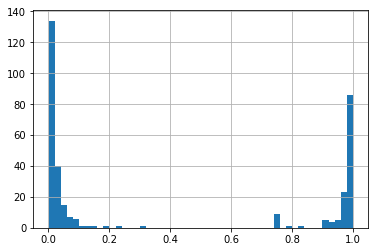

In [39]:
# Check out predicted probabilities: Distribution should be balanced
prob_col = 'prediction_cult_prob_yes'
cult_df[prob_col].hist(bins=50)

## Evaluate algorithms: Relational perspective

In [18]:
######################################################
# Prepare training and validation data
######################################################

# Separate training and final validation data set. First remove class
# label from data (X). Setup target class (Y)
# Then make the validation set 10% of the entire
# set of labeled data (X_validate, Y_validate)

relt_df = relt_df[['text', 'relational_score']]
print("Number of cases:", str(X_relt.shape[0]))

valueArray = relt_df.values
Y = valueArray[:,1]
Y = Y.astype('float')
print("Number of codes (should match):", str(len(Y)))

test_size = 0.2
seed = 3
X_train, X_validate, Y_train, Y_validate = train_test_split(X_relt, Y, test_size=test_size, random_state=seed)

print(f'Y_train Distribution: {Counter(Y_train).most_common()}')

Number of cases: 343
Number of codes (should match): 343
Y_train Distribution: [(0.0, 183), (1.0, 91)]


In [19]:
######################################################
# Oversample to desirable ratio
######################################################

X_balanced, Y_balanced = resample_data(
    X_relt, Y, 
    undersample=undersample, 
    sampling_ratio=sampling_ratio)

Y_train: Counter({0.0: 229, 1.0: 114})
Y_resample: Counter({1.0: 229, 0.0: 229})


In [23]:
mlp = MLPClassifier(max_iter=100, activation='relu')

parameter_space = {
    'hidden_layer_sizes': [(50,50), (50,50,2), (50,), (100,100), (100,100,2), (100,)],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1],
    'learning_rate': ['constant','adaptive'],
}

In [25]:
clf = GridSearchCV(mlp, parameter_space, n_jobs=40, cv=3)
clf.fit(X_balanced, Y_balanced)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=100), n_jobs=40,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1],
                         'hidden_layer_sizes': [(50, 50), (50, 50, 2), (50,),
                                                (100, 100), (100, 100, 2),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [26]:
# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'alpha': 0.1, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'solver': 'adam'}
0.613 (+/-0.325) for {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.935 (+/-0.065) for {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.504 (+/-0.008) for {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.928 (+/-0.074) for {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.502 (+/-0.003) for {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 2), 'learning_rate': 'constant', 'solver': 'sgd'}
0.667 (+/-0.417) for {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 2), 'learning_rate': 'constant', 'solver': 'adam'}
0.598 (+/-0.282) for {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 2), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.667 (+/-0.471) for {'alpha': 0.0001, 'hidden_la

In [27]:
#plotting model with most optimized parameters found above
clf = MLPClassifier(random_state=1, max_iter=200, activation='relu', 
                   alpha=0.0001, hidden_layer_sizes=(50, 50), 
                    learning_rate='adaptive', solver='adam').fit(X_balanced, Y_balanced)
#clf.predict_proba(X_validate[:1])

print(clf.score(X_balanced, Y_balanced))
print(clf.score(X_validate, Y_validate))

1.0
1.0


In [48]:
######################################################
# Use different algorithms to build models
######################################################

models = []
models.append(('K-Nearest Neighbors (KNN)', KNeighborsClassifier()))
models.append(('Random Forest (RF)', RandomForestClassifier(random_state=seed)))
models.append(('Decision Tree (DT)', DecisionTreeClassifier(random_state=seed)))
models.append(('Multinomial Naive Bayes (MNB)', MultinomialNB()))
models.append(('Logistic Regression (LR)', LogisticRegression(random_state=seed)))
models.append(('Support Vector Machine (SVM)', SVC(gamma='auto')))
models.append(('Multi-Layer Perceptron (MLP) (Optimized)', clf))

# Evaluate algorithms using 10-fold cross validation
results, names = show_kfold_output(models=models, 
                                   X=X_balanced, 
                                   Y=Y_balanced)

K-Nearest Neighbors (KNN):

Mean (std):	 0.6223 (0.4848)
Accuracy:	 {1, 4}

Confusion matrix:
 [[163  66]
 [ 10 219]]

Report:
               precision    recall  f1-score   support

         0.0       0.94      0.71      0.81       229
         1.0       0.77      0.96      0.85       229

    accuracy                           0.83       458
   macro avg       0.86      0.83      0.83       458
weighted avg       0.86      0.83      0.83       458


Random Forest (RF):

Mean (std):	 0.5022 (0.5)
Accuracy:	 {1, 4}

Confusion matrix:
 [[220   9]
 [  8 221]]

Report:
               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       229
         1.0       0.96      0.97      0.96       229

    accuracy                           0.96       458
   macro avg       0.96      0.96      0.96       458
weighted avg       0.96      0.96      0.96       458


Decision Tree (DT):

Mean (std):	 0.5546 (0.497)
Accuracy:	 {1, 4}

Confusion matrix:
 [[195  34]


In [49]:
######################################################
# Save best model
######################################################

#rf_relt = RandomForestClassifier(random_state=seed).fit(X_balanced, Y_balanced)
joblib.dump(clf, relt_model_fp)

['/home/jovyan/work/classification/models/classifier_relt_012021.joblib']

### Validation step: Use selected model to predict class probabilities in training data

In [23]:
# Load model
#relt_model_fp = model_fp + 'classifier_relt_012021.joblib' # model filepath
#clf = joblib.load(relt_model_fp)

In [30]:
# Make predictions
tqdm.pandas(desc = "Predicting: relational persp.")
relt_df[['prediction_relt','prediction_relt_prob_yes','prediction_relt_prob_no']] = relt_df['text'].progress_apply(lambda sentlist: pd.Series(compute_predictions([' '.join(sent) for sent in sentlist], relt_vectorizer, clf)))

Predicting: relational persp.: 100%|██████████| 343/343 [00:04<00:00, 82.38it/s] 


In [31]:
# Check out predictions: labels should be balanced
pred_col = 'prediction_relt'
relt_df[pred_col].value_counts()

no     238
yes    105
Name: prediction_relt, dtype: int64

In [32]:
# Compare to distribution of labeled data
print(f'Distribution of labeled relational data: {Counter(relt_df.values[:,1]).most_common()}')

Distribution of labeled relational data: [(0.0, 229), (1.0, 114)]


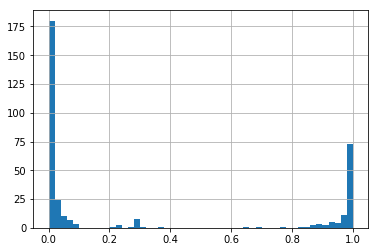

In [33]:
# Check out predicted probabilities: Distribution should be balanced
prob_col = 'prediction_relt_prob_yes'
relt_df[prob_col].hist(bins=50)

## Evaluate algorithms: Demographic perspective

In [34]:
######################################################
# Prepare training and validation data
######################################################

# Separate training and final validation data set. First reltove class
# label from data (X). Setup target class (Y)
# Then make the validation set 10% of the entire
# set of labeled data (X_validate, Y_validate)

demog_df = demog_df[['text', 'demographic_score']]
print("Number of cases:", str(X_demog.shape[0]))

valueArray = demog_df.values
Y = valueArray[:,1]
Y = Y.astype('float')
print("Number of codes (should match):", str(len(Y)))

test_size = 0.2
seed = 3
X_train, X_validate, Y_train, Y_validate = train_test_split(X_demog, Y, test_size=test_size, random_state=seed)

print(f'Y_train Distribution: {Counter(Y_train).most_common()}')

Number of cases: 349
Number of codes (should match): 349
Y_train Distribution: [(0.0, 195), (1.0, 84)]


In [35]:
######################################################
# Oversample to desirable ratio
######################################################

X_balanced, Y_balanced = resample_data(
    X_demog, Y, 
    undersample=undersample, 
    sampling_ratio=sampling_ratio)

Y_train: Counter({0.0: 248, 1.0: 101})
Y_resample: Counter({1.0: 248, 0.0: 248})


In [36]:
mlp = MLPClassifier(max_iter=100, activation='relu')

parameter_space = {
    'hidden_layer_sizes': [(50,50), (50,50,2), (50,), (100,100), (100,100,2), (100,)],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1],
    'learning_rate': ['constant','adaptive'],
}

In [37]:
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_balanced, Y_balanced)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1],
                         'hidden_layer_sizes': [(50, 50), (50, 50, 2), (50,),
                                                (100, 100), (100, 100, 2),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [38]:
# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'alpha': 0.1, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'solver': 'adam'}
0.498 (+/-0.003) for {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.962 (+/-0.054) for {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.500 (+/-0.005) for {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.958 (+/-0.060) for {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.629 (+/-0.355) for {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 2), 'learning_rate': 'constant', 'solver': 'sgd'}
0.516 (+/-0.046) for {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 2), 'learning_rate': 'constant', 'solver': 'adam'}
0.500 (+/-0.005) for {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 2), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.653 (+/-0.440) for {'alpha': 0.0001, 'hidden_la

In [39]:
#plotting model with most optimized parameters found above
clf = MLPClassifier(random_state=1, max_iter=200, activation='relu', 
                   alpha=0.0001, hidden_layer_sizes=(50, 50), 
                    learning_rate='adaptive', solver='adam').fit(X_balanced, Y_balanced)
#clf.predict_proba(X_validate[:1])

print(clf.score(X_balanced, Y_balanced))
print(clf.score(X_validate, Y_validate))

1.0
1.0


In [56]:
######################################################
# Use different algorithms to build models
######################################################

models = []
models.append(('K-Nearest Neighbors (KNN)', KNeighborsClassifier()))
models.append(('Random Forest (RF)', RandomForestClassifier(random_state=seed)))
models.append(('Decision Tree (DT)', DecisionTreeClassifier(random_state=seed)))
models.append(('Multinomial Naive Bayes (MNB)', MultinomialNB()))
models.append(('Logistic Regression (LR)', LogisticRegression(random_state=seed)))
models.append(('Support Vector Machine (SVM)', SVC(gamma='auto')))
models.append(('Multi-Layer Perceptron (MLP) (Optimized)', clf))

# Evaluate algorithms using 10-fold cross validation
results, names = show_kfold_output(models=models, 
                                   X=X_balanced, 
                                   Y=Y_balanced)

K-Nearest Neighbors (KNN):

Mean (std):	 0.6371 (0.4808)
Accuracy:	 {1, 4}

Confusion matrix:
 [[179  69]
 [  1 247]]

Report:
               precision    recall  f1-score   support

         0.0       0.99      0.72      0.84       248
         1.0       0.78      1.00      0.88       248

    accuracy                           0.86       496
   macro avg       0.89      0.86      0.86       496
weighted avg       0.89      0.86      0.86       496


Random Forest (RF):

Mean (std):	 0.496 (0.5)
Accuracy:	 {1, 4}

Confusion matrix:
 [[244   4]
 [  6 242]]

Report:
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       248
         1.0       0.98      0.98      0.98       248

    accuracy                           0.98       496
   macro avg       0.98      0.98      0.98       496
weighted avg       0.98      0.98      0.98       496


Decision Tree (DT):

Mean (std):	 0.5484 (0.4977)
Accuracy:	 {1, 4}

Confusion matrix:
 [[217  31]


In [57]:
######################################################
# Save best model
######################################################

#rf_demog = RandomForestClassifier(random_state=seed).fit(X_balanced, Y_balanced)
joblib.dump(clf, demog_model_fp)

['/home/jovyan/work/classification/models/classifier_demog_012021.joblib']

### Validation step: Use selected model to predict class probabilities in training data

In [27]:
# Load model
#demog_model_fp = model_fp + 'classifier_demog_012021.joblib' # model filepath
#clf = joblib.load(demog_model_fp)

In [40]:
# Make predictions
tqdm.pandas(desc = "Predicting: demographic persp.")
demog_df[['prediction_demog','prediction_demog_prob_yes','prediction_demog_prob_no']] = demog_df['text'].progress_apply(lambda sentlist: pd.Series(compute_predictions([' '.join(sent) for sent in sentlist], demog_vectorizer, clf)))

Predicting: demographic persp.: 100%|██████████| 349/349 [00:04<00:00, 81.98it/s] 


In [41]:
# Check out predictions: labels should be balanced
pred_col = 'prediction_demog'
demog_df[pred_col].value_counts()

no     258
yes     91
Name: prediction_demog, dtype: int64

In [42]:
# Compare to distribution of labeled data
print(f'Distribution of labeled cultural data: {Counter(demog_df.values[:,1]).most_common()}')

Distribution of labeled cultural data: [(0.0, 248), (1.0, 101)]


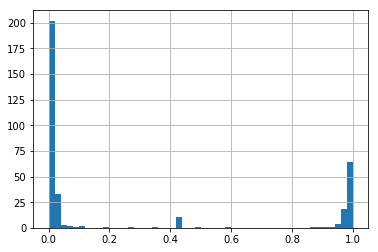

In [43]:
# Check out predicted probabilities: Distribution should be balanced
prob_col = 'prediction_demog_prob_yes'
demog_df[prob_col].hist(bins=50)